In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')
data = pd.read_csv("kbopitchingdata.csv")

print(data.head())
# 결측치 확인, games_started, games_finished, intentional_walks에 139건의 결측치가 존재하나 분석 대상에서 제외될 예정
print(data.isnull().sum())

   id  year           team  average_age  runs_per_game  wins  losses  \
0   1  2021       LG Twins         26.3           3.90    72      57   
1   2  2021         KT Wiz         28.4           4.06    75      59   
2   3  2021   Doosan Bears         27.5           4.57    70      65   
3   4  2021  Samsung Lions         28.8           4.57    75      59   
4   5  2021       NC Dinos         27.7           4.80    67      67   

   win_loss_percentage   ERA  run_average_9  ...  hit_batter  balks  \
0                0.558  3.57           3.96  ...          97    5.0   
1                0.560  3.67           4.17  ...          42    1.0   
2                0.519  4.28           4.66  ...          73    7.0   
3                0.560  4.29           4.70  ...          51    3.0   
4                0.500  4.50           4.95  ...          77    8.0   

   wild_pitches  batters_faced   WHIP  hits_9  homeruns_9  walks_9  \
0          43.0           5416  1.312     8.0         0.6      3.9   


<Axes: >

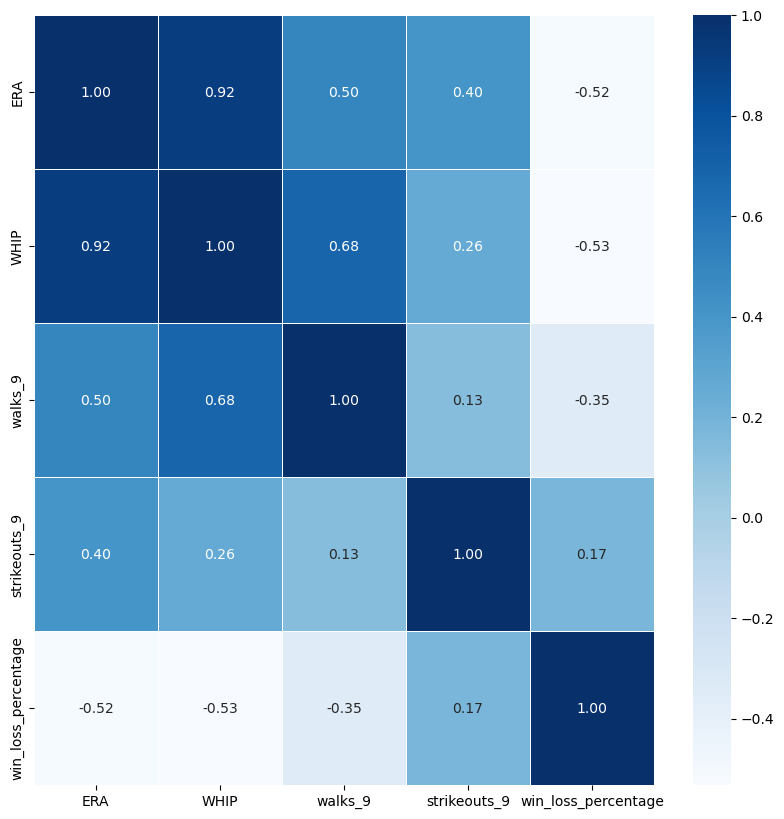

In [ ]:
# 초기 분석 도메인 : ERA, WHIP, walks_9이 낮을수록, strikeouts_9가 높을수록 win_loss_percentage가 높다
clean_data = data.drop(['id', 'year', 'team'], axis=1)
chose_data = clean_data[['ERA','WHIP','walks_9','strikeouts_9', 'win_loss_percentage']]
plt.figure(figsize=(10,10))
sns.heatmap(data=chose_data.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

In [30]:
#일부 변수 간 높은 상관관계를 보임으로 다중공선성 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

data_X = chose_data.drop('win_loss_percentage', axis=1)
vif_data = pd.DataFrame()
vif_data["Feature"] = data_X.columns
vif_data["VIF"] = [variance_inflation_factor(data_X.values, i) for i in range(len(data_X.columns))]

vif_data

,Feature,VIF
0,ERA,94.659195
1,WHIP,245.833803
2,walks_9,100.747066
3,strikeouts_9,27.881065


In [31]:
#VIF 값을 줄이기 위해 WHIP 변수 제거 후 재확인

chose_data_X_new = clean_data[['ERA','walks_9','strikeouts_9']]
vif_data_new = pd.DataFrame()
vif_data_new["Feature"] = chose_data_X_new.columns
vif_data_new["VIF"] = [variance_inflation_factor(chose_data_X_new.values, i) for i in range(len(chose_data_X_new.columns))]

vif_data_new

,Feature,VIF
0,ERA,50.942477
1,walks_9,41.880304
2,strikeouts_9,25.822933


In [ ]:
# 회귀 모델 적용 전 테스트셋 분리 및 데이터 스케일링 진행

data_Y = data[['win_loss_percentage']]

# 스케일링(표준화)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_X)

# 테스트셋 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, data_Y, test_size=0.2, random_state=42)

array([[ 1.07110848,  0.58611879,  0.51759792, -0.2042524 ],
       [ 1.23134069,  1.22951969,  0.92191262,  1.2208428 ],
       [-0.46445017, -0.28334189, -0.08887413,  0.6340389 ],
       ...,
       [ 0.24324208,  0.27311294,  0.11328322,  0.6340389 ],
       [ 0.68388065,  1.08171138,  2.13485671, -1.6293476 ],
       [ 0.20318403,  0.94259767,  2.13485671,  0.38255151]])

In [64]:
# 다중공선성 문제 해결을 위해 Ridge/Lasso 회귀 진행
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print(f"Ridge 회귀 지표 - MSE : {ridge_mse:.4f}, R^2 : {ridge_r2:.4f}")

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)
lasso_r2 = r2_score(y_test, y_pred_lasso)

print(f"Lasso 회귀 지표 - MSE : {lasso_mse:.4f}, R^2 : {lasso_r2:.4f}")
print("Lasso 계수:", lasso.coef_)

Ridge 회귀 지표 - MSE : 0.0039, R^2 : 0.3951
Lasso 회귀 지표 - MSE : 0.0037, R^2 : 0.4242
Lasso 계수: [-0.05816837  0.         -0.00418648  0.03982624]


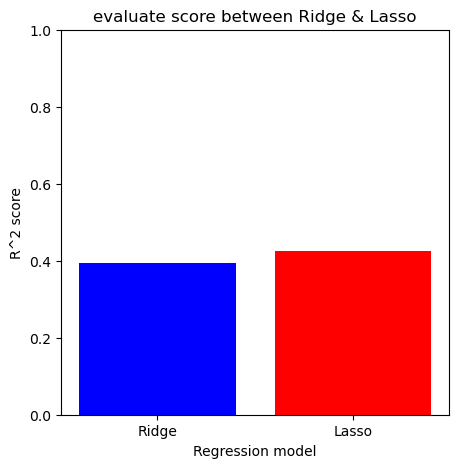

In [54]:
# 회귀 결과 시각화, R2 값을 기준으로 Lasso는 실제 데이터를 설명하지 못하는 모델로 판별
plt.figure(figsize=(5,5))
plt.bar(["Ridge", "Lasso"], [ridge_r2, lasso_r2], color=['blue', 'red'])
plt.xlabel("Regression model")
plt.ylabel("R^2 score")
plt.title("evaluate score between Ridge & Lasso")
plt.ylim(0,1)
plt.show()

In [73]:
# 해당 모델의 최적 alpha 값을 찾기 위한 하이퍼파라미터 튜닝 수행
import optuna

def objective_ridge(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e3) #로그 단위로 검색 수행
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    trial.set_user_attr("r2_score", r2)
    return mse

study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge, n_trials=100)

best_ridge_alpha = study_ridge.best_params['alpha']
best_ridge_mse = study_ridge.best_value
best_ridge_r2 = study_ridge.best_trial.user_attrs["r2_score"]



def objective_lasso(trial):
    alpha = trial.suggest_loguniform('alpha', 1e-3, 1e3) #로그 단위로 검색 수행
    model = Lasso(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    trial.set_user_attr("r2_score", r2)
    return mse

study_lasso = optuna.create_study(direction='minimize')
study_lasso.optimize(objective_lasso, n_trials=100)

best_lasso_alpha = study_lasso.best_params['alpha']
best_lasso_mse = study_lasso.best_value
best_lasso_r2 = study_lasso.best_trial.user_attrs["r2_score"]

print(f"Ridge 최적 alpha: {best_ridge_alpha:.4f}, MSE: {best_ridge_mse:.4f}, r2_score : {best_ridge_r2:.4f}")
print(f"Lasso 최적 alpha: {best_lasso_alpha:.4f}, MSE: {best_lasso_mse:.4f}, r2_score : {best_lasso_r2:.4f}")

[I 2025-02-13 19:55:21,650] A new study created in memory with name: no-name-1379466e-afb3-4570-9a02-f646036bf708
C:\Users\goodm\AppData\Local\Temp\ipykernel_1640\2067477444.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-02-13 19:55:21,655] Trial 0 finished with value: 0.0035522262917423307 and parameters: {'alpha': 53.47144831650231}. Best is trial 0 with value: 0.0035522262917423307.
C:\Users\goodm\AppData\Local\Temp\ipykernel_1640\2067477444.py:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-02-13 19:55:21,659] Trial 1 finished with value: 0.003906605356295381 and parameters: {'alpha': 0.7464372605285333}. Best is trial 0 with value: 0.003552226

Ridge 최적 alpha: 46.3387, MSE: 0.0036, r2_score : 0.4485
Lasso 최적 alpha: 0.0035, MSE: 0.0037, r2_score : 0.4272


In [ ]:
# Ridge 최적 alpha: 46.2669, MSE: 0.0036, r2_score : 0.4485
# Lasso 최적 alpha: 0.0034, MSE: 0.0037, r2_score : 0.4272
# optuna 과정 시각화
import optuna.visualization as vis

vis.plot_optimization_history(study_ridge).show()
vis.plot_optimization_history(study_lasso).show()

In [ ]:
# r2 score에서 만족스러운 성능이 나오지 않음, tree 기반 모델 학습 및 비교
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)  
    learning_rate = trial.suggest_loguniform('learning_rate', 0.001, 0.3) 
    max_depth = trial.suggest_int('max_depth', 2, 10) 

    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate, 
        max_depth=max_depth,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    trial.set_user_attr("r2_score", r2)
    return mse  # MSE 최소화

study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gb, n_trials=100)

best_gb_params = study_gb.best_params
best_gb_mse = study_gb.best_value
best_gb_r2 = study_gb.best_trial.user_attrs["r2_score"]


def objective_xgb(trial):
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 50, 500),
        "learning_rate" : trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "max_depth" : trial.suggest_int("max_depth", 3, 10),
        "subsample" : trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree" : trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    model = XGBRegressor(**params, random_state=42) # **의미는 딕셔너리 언패킹, 딕셔너리의 key-value 값을 개별적인 인자로 전달하는 역할
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    trial.set_user_attr("r2_score", r2)
    return mse

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=100)

best_xgb_params = study_xgb.best_params
best_xgb_mse = study_xgb.best_value
best_xgb_r2 = study_xgb.best_trial.user_attrs["r2_score"]


def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int('n_estimators', 50, 500),
        "learning_rate": trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "max_depth": trial.suggest_int('max_depth', 3, 10),
        "num_leaves": trial.suggest_int('num_leaves', 20, 200),
        "subsample": trial.suggest_uniform('subsample', 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }
    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    trial.set_user_attr("r2_score", r2)
    return mse

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=100)

best_lgb_params = study_lgb.best_params
best_lgb_mse = study_lgb.best_value
best_lgb_r2 = study_lgb.best_trial.user_attrs["r2_score"]


def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int('iterations', 50, 500),
        "learning_rate": trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        "depth": trial.suggest_int('depth', 3, 10),
        "l2_leaf_reg": trial.suggest_loguniform('l2_leaf_reg', 1, 10),
    }
    model = CatBoostRegressor(**params, random_state=42, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    trial.set_user_attr("r2_score", r2)
    return mse

study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat, n_trials=100)

best_cat_params = study_cat.best_params
best_cat_mse = study_cat.best_value
best_cat_r2 = study_cat.best_trial.user_attrs["r2_score"]

[I 2025-02-13 19:51:28,429] A new study created in memory with name: no-name-d35cf9fe-9bd1-4ed1-aeff-9d2b604cdb93
C:\Users\goodm\AppData\Local\Temp\ipykernel_1640\1085831231.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

c:\Users\goodm\anaconda3\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

[I 2025-02-13 19:51:28,539] Trial 0 finished with value: 0.004566741487505274 and parameters: {'n_estimators': 230, 'learning_rate': 0.12630702354980605, 'max_depth': 5}. Best is trial 0 with value: 0.004566741487505274.
C:\Users\goodm\AppData\Local\Temp\ipykernel_1640\1085831231.py:9: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed i

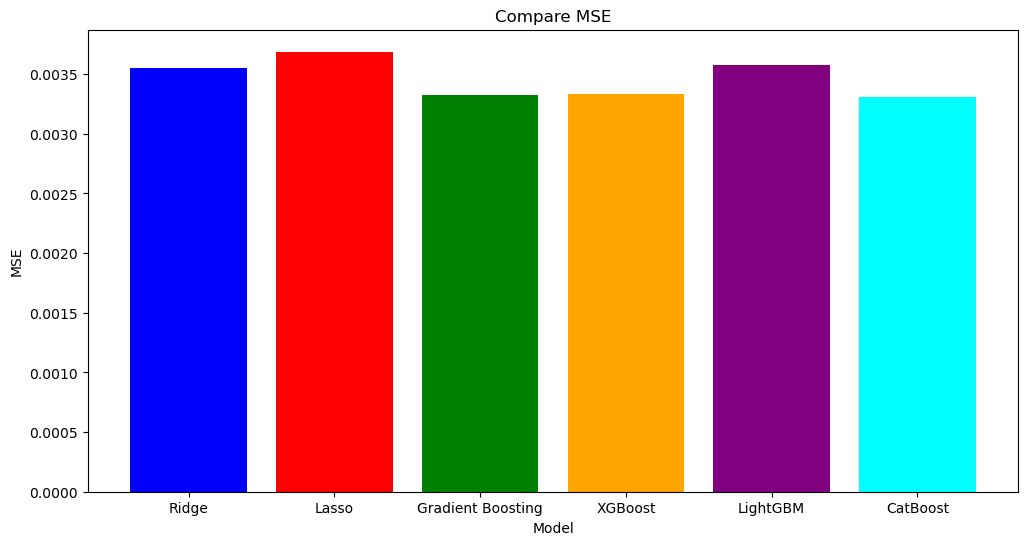

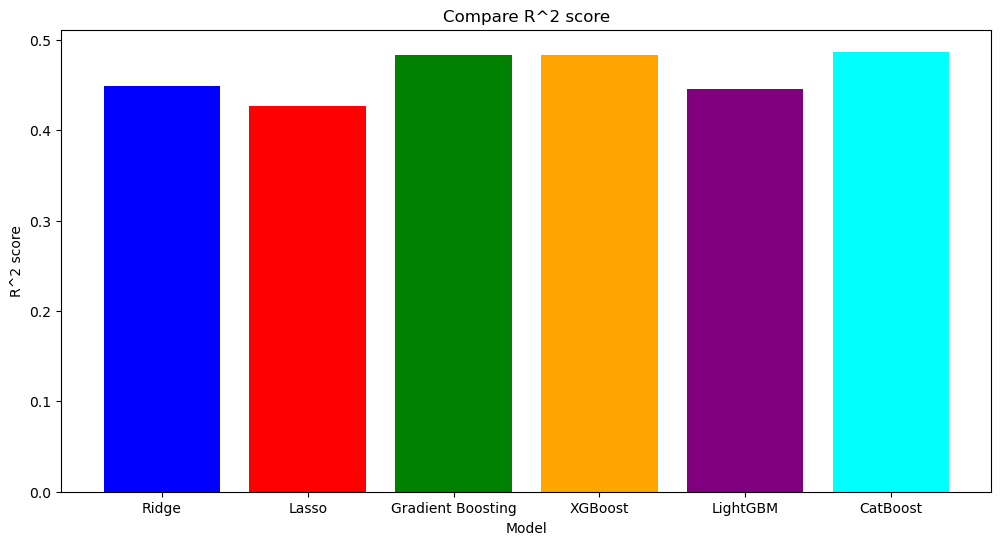

,Model,MSE,R^2
0,Ridge,0.003550,0.448482
1,Lasso,0.003687,0.427219
2,Gradient Boosting,0.003329,0.482952
3,XGBoost,0.003331,0.482643
4,LightGBM,0.003572,0.445085
5,CatBoost,0.003304,0.486766


In [78]:
# 모든 모델 성능 정리

results = pd.DataFrame({
    "Model": ["Ridge", "Lasso", "Gradient Boosting", "XGBoost", "LightGBM", "CatBoost"],
    "MSE": [best_ridge_mse, best_lasso_mse, best_gb_mse, best_xgb_mse, best_lgb_mse, best_cat_mse],
    "R^2": [best_ridge_r2, best_lasso_r2, best_gb_r2, best_xgb_r2, best_lgb_r2, best_cat_r2]
})

# 성능 비교 시각화 (MSE)
plt.figure(figsize=(12, 6))
plt.bar(results["Model"], results["MSE"], color=["blue", "red", "green", "orange", "purple", "cyan"])
plt.xlabel("Model")
plt.ylabel("MSE")
plt.title("Compare MSE")
plt.show()

#  성능 비교 시각화 (R^2 Score)
plt.figure(figsize=(12, 6))
plt.bar(results["Model"], results["R^2"], color=["blue", "red", "green", "orange", "purple", "cyan"])
plt.xlabel("Model")
plt.ylabel("R^2 score")
plt.title("Compare R^2 score")
plt.show()

results

In [ ]:
# 성능이 비교적 양호한 두 모델 Gradient Boosting, CatBoost에 대해 K-fold 교차 검증 수행

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer
import numpy as np

k=5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

scoring = {"MSE" : make_scorer(mean_squared_error, greater_is_better=False),
           "R2" : make_scorer(r2_score)}

gb_model = GradientBoostingRegressor(**best_gb_params, random_state=42)
gb_r2_scores = cross_val_score(gb_model, data_X, data_Y, cv=kf, scoring="r2")
gb_mse_scores = cross_val_score(gb_model, data_X, data_Y, cv=kf, scoring="neg_mean_squared_error")

cat_model = CatBoostRegressor(**best_cat_params, random_state=42, verbose=0) #verbose=0 은 로그 출력 X
cat_r2_scores = cross_val_score(cat_model, data_X, data_Y, cv=kf, scoring="r2")
cat_mse_scores = cross_val_score(cat_model, data_X, data_Y, cv=kf, scoring="neg_mean_squared_error")

print(f"Gradient Boosting R2 Score: {np.mean(gb_r2_scores):.4f} ± {np.std(gb_r2_scores):.4f}")
print(f"Gradient Boosting MSE: {-np.mean(gb_mse_scores):.4f} ± {np.std(gb_mse_scores):.4f}")

print(f"CatBoost R2 Score: {np.mean(cat_r2_scores):.4f} ± {np.std(cat_r2_scores):.4f}")
print(f"CatBoost MSE: {-np.mean(cat_mse_scores):.4f} ± {np.std(cat_mse_scores):.4f}")

Gradient Boosting R2 Score: 0.4043 ± 0.1295
Gradient Boosting MSE: 0.0045 ± 0.0012
CatBoost R2 Score: 0.4051 ± 0.1022
CatBoost MSE: 0.0045 ± 0.0010
